Thermal Radiation Transport Reduced Order Modeling
Alternate Shifted Operator Inference Method 
Simon Butson

In [55]:
import numpy as np
import math
import pandas as pd
import scipy
import scipy.linalg as la
from scipy.integrate import solve_ivp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import h5py

import opinf

In [56]:
# Open the snapshot files to obtain radiation energy and time step data
U = []
t = np.zeros(141)

for i in range(141):
    filename = f'olson_hdf5_plt_cnt_{i:04d}'
    with h5py.File(filename, 'r') as f:
        if 'erad' in f:
            erad_data = f['erad'][...]
            if isinstance(erad_data, np.ndarray):
                erad_data = erad_data.squeeze()
                U.append(erad_data)
        if 'real scalars' in f:
              t[i] = f['real scalars'][0][1]      

Q = np.array(U)  # Convert the list to a NumPy array
Q = np.transpose(Q) # Transpose the array

print(Q.shape)

# Scale t from picoseconds
t = t*(10**12)

# Setup the x values
x = np.linspace(0,1,100)
dx = x[1]-x[0]

(100, 141)


(140,)
(100, 140)


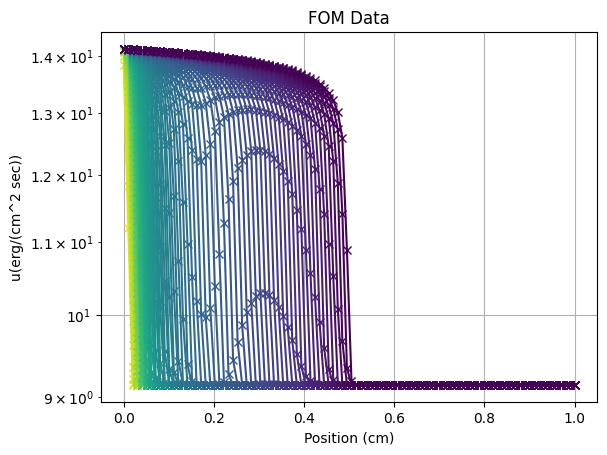

In [57]:
# Initial Conditions
# Remove flat initial conditions column from Q as it is problematic for training
Q = np.delete(Q, [0], 1)
t = np.delete(t, [0])

Q_old = Q.copy() # Save copy of initial data for comparison after solving

# Scale data logarithmically
Q = np.log10(Q)
print(t.shape)
print(Q.shape)

# Calculate intervals between times
dt = np.zeros(len(t)-1)
for i in range(len(t)-1):
    dt[i] = t[i+1]-t[i]

# Number of training snapshots
train_snaps = 100
# Plot training data

fig, ax = plt.subplots()
color = iter(plt.cm.viridis_r(np.linspace(.05, 1, train_snaps)))
for j in range(train_snaps):
    ax.plot(x, Q[:,j], color=next(color), marker='x', label=fr"$u_{{{j}}}$")

ax.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))',
       title='FOM Data')
#ax.legend()
ax.grid()
plt.yscale("log")
plt.show()

51.0
[ 2.95366005e-13 -1.11073516e-10  1.75778777e-08 -1.52102099e-06
  7.82885455e-05 -2.44554253e-03  4.55302828e-02 -4.87218655e-01
  3.90653454e+00  3.38161585e+00]
[-5.71622997e-13  9.75700422e-12  7.57241921e-09 -3.47580365e-07
  3.54338667e-06  1.41354309e+01]
14.135928


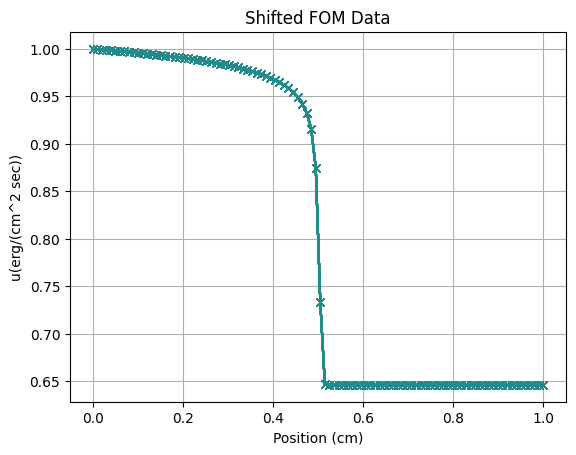

In [58]:
# Determine the points where the shock discontinuity reaches the minimum value to shift the snapshots about
shift_points = np.zeros(len(t)-1)

for ii in range(len(t)-1):
    for jj in range(100):
        if Q[jj,ii] < 9.3:
            shift_points[ii] = jj
            if Q[jj-1,ii] < 9.6: # Prevents misalignments in snapshots that have a kink near the bottom of their shock discontinuity
                shift_points[ii] -=1
            break

# Center point about which to shift
shift = shift_points[train_snaps]

print(shift)

x_shift = np.zeros(len(t))
scale = np.zeros(len(t)) 

# Collapse all of the snapshots together so a single basis mode can be identified
for p in range(train_snaps): 
    Q[:,p] = Q[:,train_snaps] 

# Fit a polynomial to model the discontinuity position as a function of time
position = np.polyfit(t[:-1],shift_points,9)
print(position)
p = np.poly1d(position)

# Polynomial function to model the intial boundary condition
initial = np.polyfit(t[:-1],Q[0,:-1],5)
print(initial)
q0_p = np.poly1d(initial)


# Normalize the data after shifting
Qmax = np.max(Q)

print(Qmax)

Q = Q/Qmax 

fig1, ax1 = plt.subplots()
color = iter(plt.cm.viridis_r(np.linspace(.05, 1, train_snaps)))
for j in range(train_snaps):
    if j % 2 == 0:
        ax1.plot(x, Q[:,j], color=next(color), marker='x', label=fr"$u_{{{j}}}$")

ax1.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))',
       title='Shifted FOM Data')
#ax1.legend()
ax1.grid()
plt.yscale("linear")
plt.show()

In [59]:
 # Take scaled and shifted intial condition
q0 = Q[:,0]


# Estimate time derivatives (dq/dt) for each training snapshot.
#Qdot_train = (Q[:, 1:train_snaps] - Q[:, :train_snaps-1]) / dt[:train_snaps-1] # dx factor used to scale down Qdot to improve stability
Qdot_train = opinf.utils.ddt_nonuniform(states = Q[:,1:train_snaps], t = t[:train_snaps-1])
Q_train = Q[:, 1:train_snaps]              # Training snapshots.
#U_train = U[:,1:train_snaps]           # Training inputs. 

print(f"shape of Q_train:\t{Q_train.shape}")
print(f"shape of Qdot_train:\t{Qdot_train.shape}")
#print(f"shape of U_train:\t{U_train.shape}")

shape of Q_train:	(100, 99)
shape of Qdot_train:	(100, 99)


PODBasis
Full-order dimension    n = 100
Reduced-order dimension r = 1


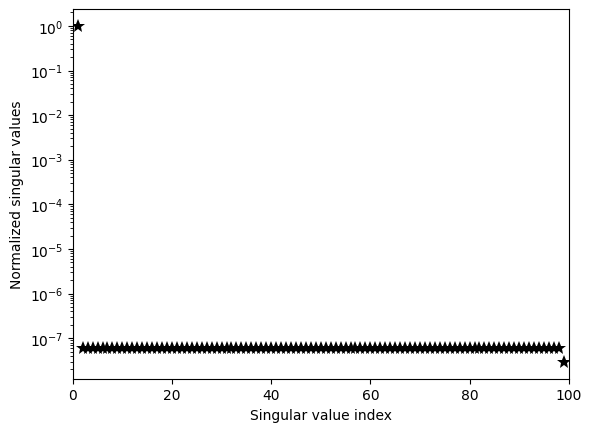

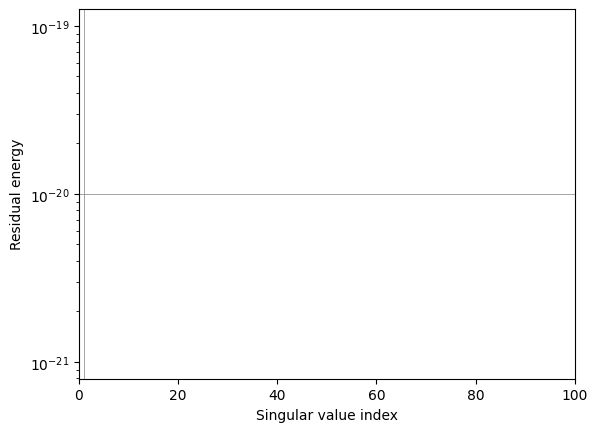

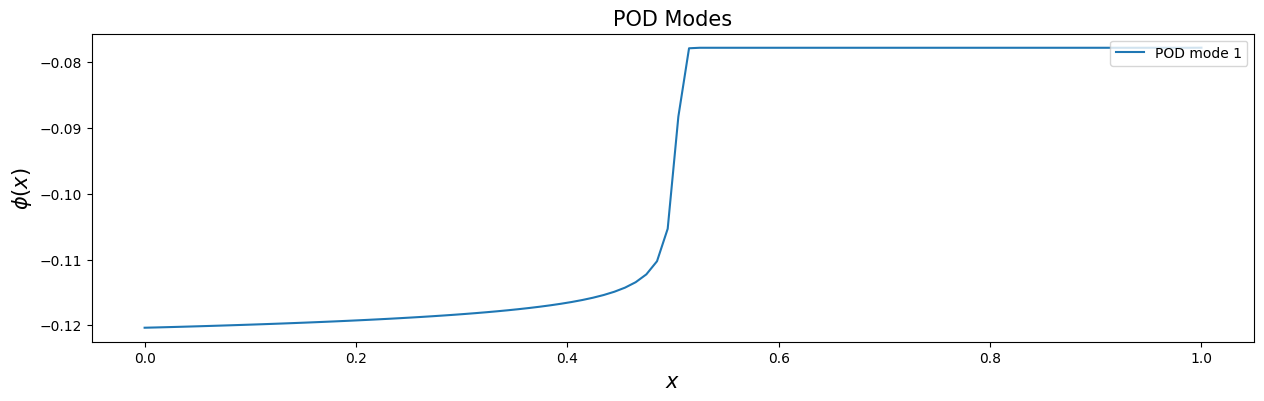

In [60]:
# Compute the POD basis, using the residual energy decay to select r.
basis = opinf.basis.PODBasis().fit(Q_train, residual_energy=1e-12)
print(basis)

rank = basis.shape[1]

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 100)

# Check the decay of the residual energy based on the singular values.
basis.plot_residual_energy(threshold=1e-20)
plt.xlim(0, 100)
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
for ii in range(rank):
    ax.plot(x, basis[:,ii],  label=f"POD mode {ii+1}")

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\phi(x)$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.legend(loc="upper right")
plt.show()

In [61]:
# Train the model.
rom = opinf.ContinuousOpInfROM(modelform="AH")

rom.fit(basis=basis, states=Q_train, ddts=Qdot_train)

# Looking at eigenvalues of A-matrix to quickly check stability
# Positive real parts suggest instability
print(np.real(np.linalg.eigvals(rom.A_.entries)))

[-1.25682e-08]


In [62]:
# Express the initial condition in the coordinates of the basis.
q0_ = basis.compress(q0)
#tmax = 80*(10**-12)
tmax = 80

# Generate a finer temporal mesh for use when solving the model
t1 = np.linspace(0,tmax,1000001)
dt1 = t1[1]-t1[0] 

print(t1)

# Can use the predict function to solve non-linear state-space models
Q_ROM = rom.predict(q0,t1, decompress=True, method='BDF') 
print(Q_ROM.shape)

# Undo normalization of ROM to obtain full values
Q_ROM = Q_ROM*Qmax
#Q_ROM = 10**Q_ROM # Bring ROM out of log10 scale

[0.000000e+00 8.000000e-05 1.600000e-04 ... 7.999984e+01 7.999992e+01
 8.000000e+01]
(100, 1000001)


1000001
13
0.004515891931820448
25
0.004515812444470413
[ 49.  47.  45.  38.  19.   2. -13. -25.]
0.0010462212541120452
0.06316017851829948
0.5252411720829447
3.9058339699932114
19.56754576157343
39.56754576157341
59.56754576157318
79.56754576157414


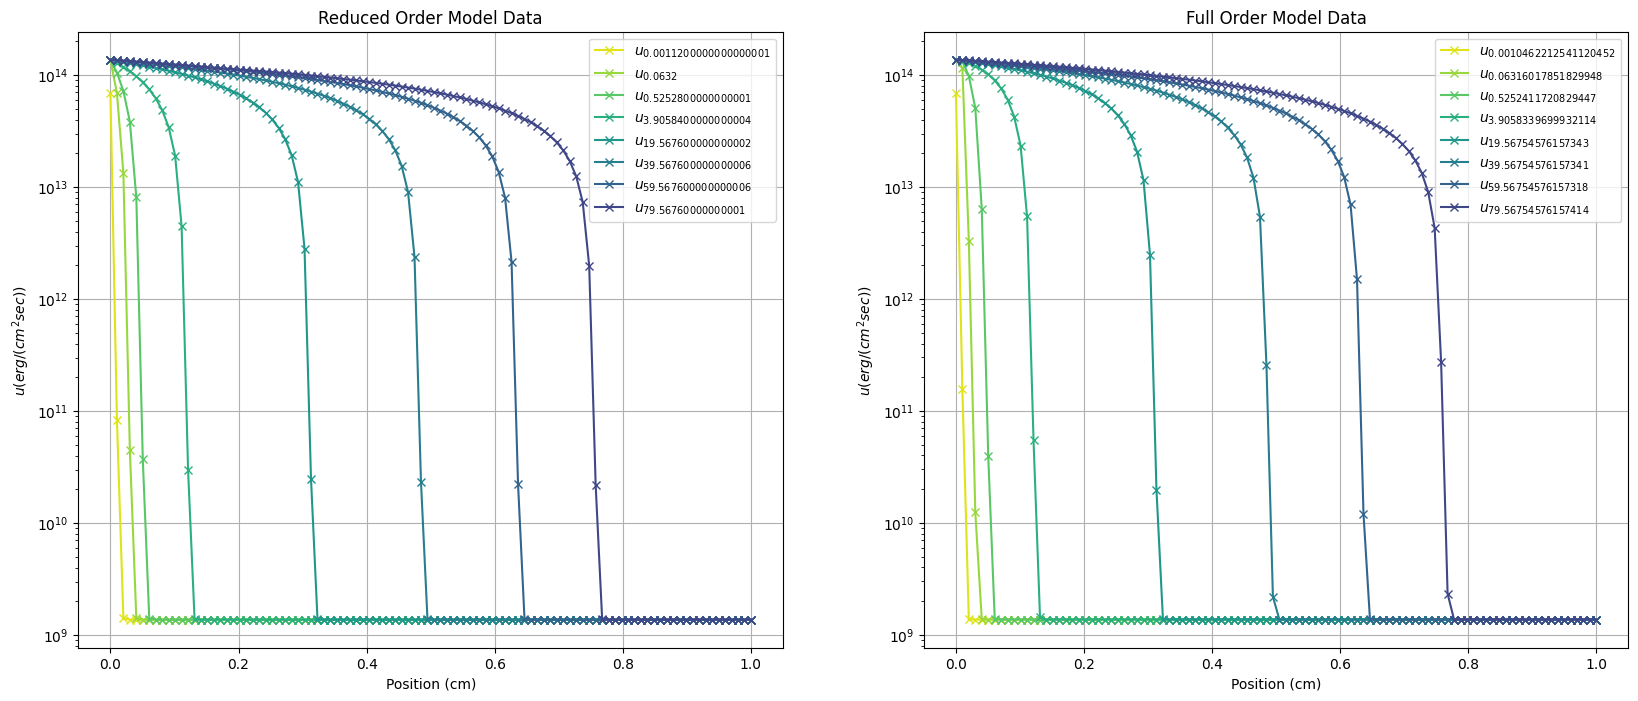

In [63]:
# Plot the solved model as a function of time 

t_solve = Q_ROM.shape[1]
print(t_solve)

# Shift Times
plot_values = np.linspace(0, len(t)-2, 8) # Equally spaced snapshot values to plot at
plot_times = t[plot_values.astype(int)] # Array of times corresponding to the snapshots to be plotted
plot_indices = np.zeros(8) 
t_shift = t[train_snaps] # Time corresponding to the center shift snapshot
count = 0
for index in range(len(plot_times)):
    while t1[count] < plot_times[index]:
        count+=1
    plot_indices[index] = count # Finds the index in the ROM time array corresponding to the snapshot times to be plotted

x_shiftROM = np.zeros_like(plot_indices)
x_shiftROM2 = np.zeros_like(plot_indices)
for num1 in range(len(plot_indices)):
    x_shiftROM[num1] = round((shift-shift_points[int(plot_values[num1])])) # Exact shift method for times corresponding to snapshots  
    #x_shiftROM[num1] = round(shift-p(plot_times[num1])) # Polynomial position generalizable to any time 
    #x_shiftROM[0] += 1
    Q_ROM[:,int(plot_indices[num1])] = np.roll(Q_ROM[:,int(plot_indices[num1])], -1*int(x_shiftROM[num1]))
#Remove jump discontinuities and extrapolate values as needed
    for num2 in range(99):
        if plot_times[num1] < t_shift:
           if Q_ROM[num2+1,int(plot_indices[num1])] - Q_ROM[num2,int(plot_indices[num1])] > 3:
               Q_ROM[num2+1,int(plot_indices[num1])] = Q_ROM[num2,int(plot_indices[num1])]
        else:
            boundary_index = np.argmax(Q_ROM[:,int(plot_indices[num1])])
            print(boundary_index)
            slope = Q_ROM[boundary_index,int(plot_indices[num1])]-Q_ROM[boundary_index+1,int(plot_indices[num1])]
            print(slope)
            boundary_val = np.max(Q_ROM[:,int(plot_indices[num1])])
            counter = boundary_index-1
            while(counter >= 0):
                Q_ROM[int(counter),int(plot_indices[num1])] = Q_ROM[int(counter+1),int(plot_indices[num1])]+slope
                counter-=1
            break
            
print(x_shiftROM)

# Scale final results based on initial conditions
for ii in range(len(plot_indices)):
    scale_factor = (Q_ROM[0,int(plot_indices[ii])]-9.137)/(np.log10(Q_old[0,int(plot_values[ii])])-9.137)
    Q_ROM[:,int(plot_indices[ii])] = np.where((Q_ROM[:,int(plot_indices[ii])]-9.137) > 0,(Q_ROM[:,int(plot_indices[ii])]-9.137)/scale_factor,0) + 9.137

# Plot both the ROM & FOM in log10 space (9 to 14 instead of 10^9 to 10^14) for comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
color1 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
color2 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for n in plot_indices:
        ax1.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x', label=fr"$u_{{{t1[int(n)]}}}$")

for m in plot_values:
        ax2.plot(x, Q_old[:,int(m)], color=next(color2), marker='x', label=fr"$u_{{{t[int(m)]}}}$")
        #print(Q_old[0,int(m)])
        print(t[int(m)])
    
ax1.set(xlabel=fr"Position (cm)", ylabel=fr"$u(erg/(cm^2 sec))$",
       title='Reduced Order Model Data')
ax1.legend()
ax1.grid()
ax2.set(xlabel=fr"Position (cm)", ylabel=fr"$u(erg/(cm^2 sec))$",
       title='Full Order Model Data')
ax2.legend()
ax2.grid()
ax1.set_yscale("log")
ax2.set_yscale("log")
plt.show()


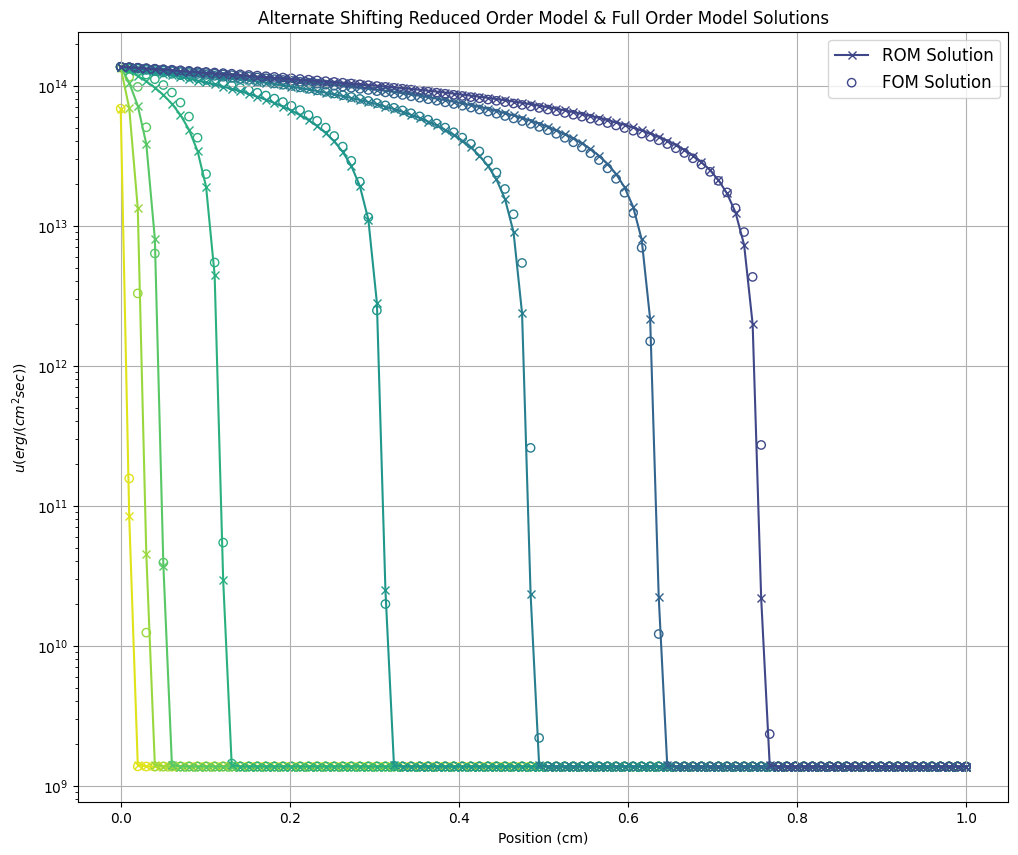

Mean absolute percentage error at time t = 0.0011200000000000001 is 0.5331110486234677 %
Mean absolute percentage error at time t = 0.0632 is 6.1467065640589 %
Mean absolute percentage error at time t = 0.5252800000000001 is 1.0721909078312537 %
Mean absolute percentage error at time t = 3.9058400000000004 is 2.126910130358404 %
Mean absolute percentage error at time t = 19.567600000000002 is 1.939198821156295 %
Mean absolute percentage error at time t = 39.567600000000006 is 3.1358987306529196 %
Mean absolute percentage error at time t = 59.567600000000006 is 3.3965287780734235 %
Mean absolute percentage error at time t = 79.56760000000001 is 3.900309623865689 %
The max error is:  305.9538088532874 %


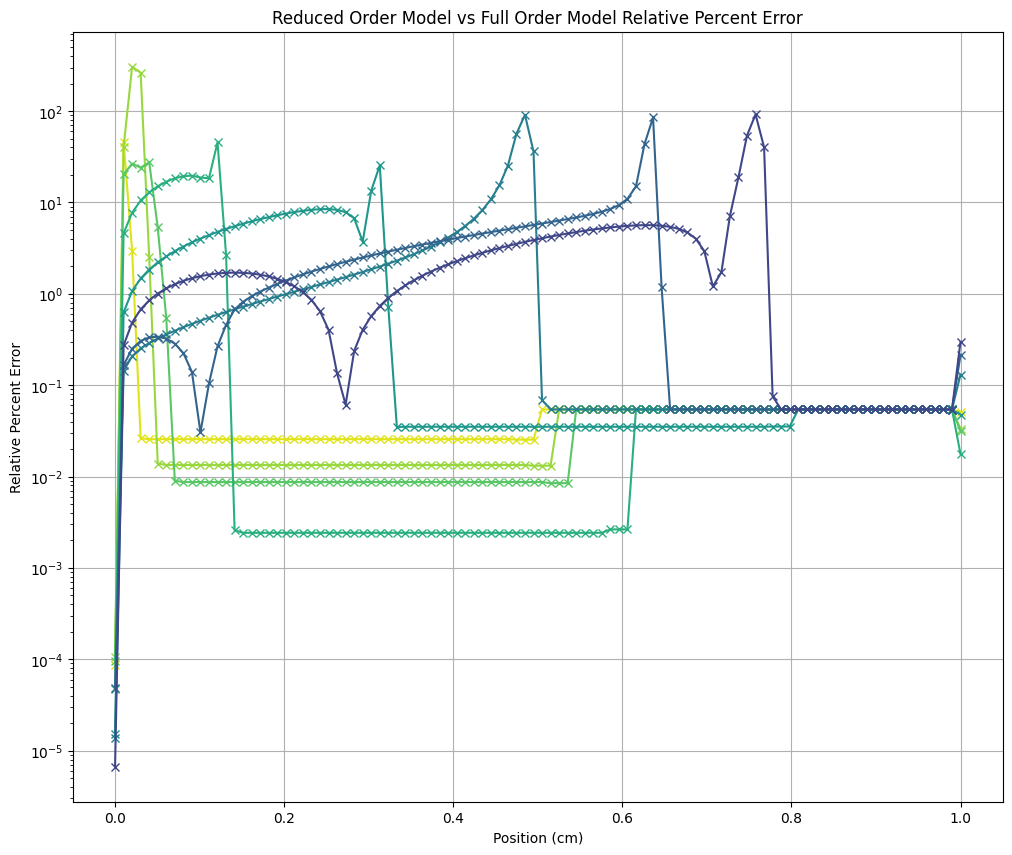

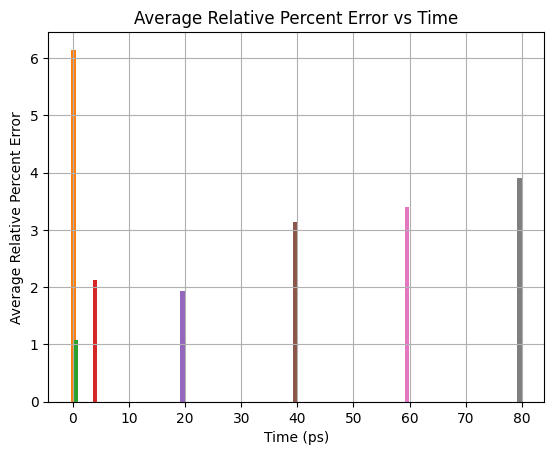

In [54]:
# Plot the ROM & FOM on the same plot for direct comparison
# FOM data plotted using x's and ROM data plotted as a continuous line
fig, ax = plt.subplots()
color1 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
color2 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for n in plot_indices:
        #ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x', label=fr"$u_{{{t1[int(n)]}}}$")
        if n == plot_indices[7]:
            ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x', label = "ROM Solution")
        else:
            ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x')

for m in plot_values:
    if m == plot_values[7]:
        ax.scatter(x, Q_old[:,int(m)], color=next(color2), marker='o',facecolor='none', label="FOM Solution")
    else:
        ax.scatter(x, Q_old[:,int(m)], color=next(color2), marker='o',facecolor='none')

ax.set(xlabel=fr"Position (cm)", ylabel=fr"$u(erg/(cm^2 sec))$",
       title='Alternate Shifting Reduced Order Model & Full Order Model Solutions')
ax.legend(fontsize=12)
ax.grid()
ax.set_yscale("log")
fig.set_size_inches(12,10)
plt.show()

# Calculate & Plot Error
fig2, ax2 = plt.subplots()
color3 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))

error = np.zeros((100,len(plot_indices)))
mean_error = np.zeros(8)

for i in range(len(plot_indices)):
    #error[:,i] = 100*(10**Q_ROM[:,int(plot_indices[i])] - Q_old[:,int(plot_values[i])])/(10**Q_ROM[:,int(plot_indices[i])]) # Error in %
    error[:,i] = 100*np.abs((Q_old[:,int(plot_values[i])] - 10**Q_ROM[:,int(plot_indices[i])])/Q_old[:,int(plot_values[i])]) # Error in %
    #ax2.plot(x, error[:,i], color=next(color3), label=fr"$u_{{{t1[int(plot_indices[i])]}}}$")
    ax2.plot(x, error[:,i], color=next(color3), marker='x')
    print("Mean absolute percentage error at time t =", t1[int(plot_indices[i])], "is", np.mean(np.abs(error[:,i])), "%")
    mean_error[i] = np.mean(np.abs(error[:,i]))

print("The max error is: ", np.max(np.abs(error)),"%")

ax2.set(xlabel='Position (cm)', ylabel='Relative Percent Error', title='Reduced Order Model vs Full Order Model Relative Percent Error')
#ax2.legend()
ax2.grid()
ax2.set_yscale("log")
fig2.set_size_inches(12,10)
plt.show()

fig3, ax3 = plt.subplots()
color4 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for k in range(len(plot_indices)):
    ax3.bar(t1[int(plot_indices[k])],mean_error[k])
ax3.set(xlabel='Time (ps)', ylabel='Average Relative Percent Error', title='Average Relative Percent Error vs Time')
ax3.grid()
plt.show()